
# 02 — Feature Engineering & Target Correlations

This notebook extends the baseline by computing **simple, robust features** for both the **prompt** and the **response**, then correlates each feature with the **target** (default: `overall_score`).

**Features (for both prompt and response):**
- `word_count` — number of tokens (alphanumeric).
- `char_len` — total characters.
- `avg_word_len` — average token length.
- `verb_count` — number of verb-like tokens (via spaCy if available; otherwise a light heuristic).

**Outputs saved:**
- `features_engineered.csv` — engineered features only
- `feature_correlations.csv` — correlations vs target
- `df_with_features.csv` — original df with features appended


In [5]:

# === 1) Imports & basic settings ===
import os, re, math, json, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.width", 120)

# Set a default CSV path to try if `df` is not already defined in the kernel.
CSV_PATHS_TO_TRY = [
    "train.csv",
    "Train.csv",
    "data.csv",
    "dataset.csv"
]
try:
    df  # noqa: F821
    if not isinstance(df, pd.DataFrame):
        raise NameError
    print("Using existing `df` found in the environment:", df.shape)
except NameError:
    df = None
    for path in CSV_PATHS_TO_TRY:
        if os.path.exists(path):
            print(f"Loading data from: {path}")
            df = pd.read_csv(path)
            break
# If you store your validation separately, you can set this for later experiments.
VALIDATION_CSV_PATHS = [
    "validation.csv",
    "Validation.csv"
]
df["overall_score"] = df[["helpfulness","correctness","coherence","complexity","verbosity"]].sum(axis=1, min_count=1)
# Target column candidates (first match is used).
TARGET_CANDIDATES = ["overall_score", "score", "target", "label", "rating"]
PROMPT_CANDIDATES = ["prompt", "instruction", "input", "question"]
RESPONSE_CANDIDATES = ["response", "output", "answer", "completion"]

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Setup complete.")


Using existing `df` found in the environment: (35331, 8)
Setup complete.


In [6]:

# === 2) Load data (reuse `df` if already present) ===
# If a DataFrame named `df` already exists in the environment, we'll use it.
# Otherwise, we attempt to load from CSV paths above.
try:
    df  # noqa: F821
    if not isinstance(df, pd.DataFrame):
        raise NameError
    print("Using existing `df` found in the environment:", df.shape)
except NameError:
    df = None
    for path in CSV_PATHS_TO_TRY:
        if os.path.exists(path):
            print(f"Loading data from: {path}")
            df = pd.read_csv(path)
            break
    if df is None:
        raise FileNotFoundError(
            "No existing `df` found and none of the default CSV paths exist. "
            "Please set `CSV_PATHS_TO_TRY` above or define a DataFrame `df`."
        )

# (Optional) Preview
display(df.head(3))
print("Data shape:", df.shape)


Using existing `df` found in the environment: (35331, 8)


,prompt,response,helpfulness,correctness,coherence,complexity,verbosity,overall_score
0,What are the three most important things to consider when deciding what technology to use to build an assist device to help an elderly person with basic needs?,"To build an assistive device to help an elderly person with basic needs, one must consider three crucial things: safety, compatibility, and ease of use. Safety is paramount, as the device must not...",3,4,4,2,2,15
1,What are the three most important things to consider when deciding what technology to use to build an assist device to help an elderly person with basic needs?,"There are many different types of assistive devices that can be used to help an elderly person with their basic needs. When deciding what technology to use to build an assistive device, it is impo...",4,3,3,2,3,15
2,What are the three most important things to consider when deciding what technology to use to build an assist device to help an elderly person with basic needs?,"When deciding what technology to use to build an assist device to help an elderly person with basic needs, there are three most important things to consider:\n\n1. The specific needs of the elderl...",4,4,4,2,2,16


Data shape: (35331, 8)


In [7]:

# === 3) Detect columns for prompt, response, and target ===

def guess_column(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

prompt_col  = guess_column(df, PROMPT_CANDIDATES)
response_col = guess_column(df, RESPONSE_CANDIDATES)
target_col  = guess_column(df, TARGET_CANDIDATES)

print("Detected columns:")
print("  prompt_col :", prompt_col)
print("  response_col:", response_col)
print("  target_col :", target_col)

# Fail with helpful messages if critical columns are missing
if prompt_col is None:
    raise KeyError(
        f"Could not find a prompt column. Tried: {PROMPT_CANDIDATES}. "
        "Please rename your prompt column or edit PROMPT_CANDIDATES."
    )
if response_col is None:
    raise KeyError(
        f"Could not find a response column. Tried: {RESPONSE_CANDIDATES}. "
        "Please rename your response column or edit RESPONSE_CANDIDATES."
    )
if target_col is None:
    raise KeyError(
        f"Could not find a target column. Tried: {TARGET_CANDIDATES}. "
        "Please rename your target or edit TARGET_CANDIDATES."
    )

# Coerce target to numeric if possible (non-numeric will become NaN and be dropped later)
df[target_col] = pd.to_numeric(df[target_col], errors="coerce")
nan_tgt = df[target_col].isna().sum()
if nan_tgt > 0:
    print(f"Note: {nan_tgt} rows have NaN in target '{target_col}' and will be ignored in correlations.")


Detected columns:
  prompt_col : prompt
  response_col: response
  target_col : overall_score


In [8]:

# === 4) Lightweight text utilities ===

_token_re = re.compile(r"[A-Za-z0-9']+")

def normalize_text(text):
    if not isinstance(text, str):
        return ""
    # Lowercase + collapse whitespace
    text = text.strip().lower()
    text = re.sub(r"\s+", " ", text)
    return text

def tokens(text):
    text = normalize_text(text)
    return _token_re.findall(text)

def word_count(text):
    return len(tokens(text))

def char_len(text):
    if not isinstance(text, str):
        return 0
    return len(text)

def avg_word_len(text):
    tks = tokens(text)
    if not tks:
        return 0.0
    return float(np.mean([len(t) for t in tks]))


In [9]:

# === 5) Verb counter ===
# Tries spaCy if available (and model present). Otherwise uses a simple heuristic:
# - Count auxiliaries and a list of common verbs.
# - Count tokens ending with common verb morphology: 'ed', 'ing' (light heuristic).

USE_SPACY = True
_spacy_ready = False
nlp = None

if USE_SPACY:
    try:
        import spacy  # type: ignore
        try:
            nlp = spacy.load("en_core_web_sm", disable=["ner", "textcat"])
            _spacy_ready = True
            print("spaCy 'en_core_web_sm' loaded for POS tagging.")
        except Exception as _:
            # Model not installed
            _spacy_ready = False
            print("spaCy installed but 'en_core_web_sm' is not available. Falling back to heuristic.")
    except Exception as _:
        _spacy_ready = False
        print("spaCy not available. Falling back to heuristic verb counter.")

COMMON_VERBS = {
    # Auxiliaries
    "be","am","is","are","was","were","been","being",
    "do","does","did","have","has","had","will","would","shall","should","can","could","may","might","must",
    # Frequent verbs
    "make","say","get","know","think","see","come","give","find","tell","work","use","want","need","look","try",
    "ask","seem","feel","leave","call","put","keep","let","begin","help","talk","turn","start","show","hear",
    "play","run","move","like","live","believe","hold","bring","happen","write","provide","sit","stand","lose",
    "pay","meet","include","continue","set","learn","change","lead","understand","watch","follow","stop","create",
    "speak","read","allow","add","spend","grow","open","walk","win","offer","remember","love","consider","appear",
    "buy","wait","serve","die","send","expect","build","stay","fall","cut","reach","kill","remain"
}

def count_verbs_spacy(text):
    if not text:
        return 0
    doc = nlp(text)  # type: ignore
    return sum(1 for tok in doc if tok.pos_ == "VERB" or tok.pos_ == "AUX")

def count_verbs_heuristic(text):
    if not text:
        return 0
    tks = tokens(text)
    cnt = 0
    for t in tks:
        if t in COMMON_VERBS:
            cnt += 1
        elif len(t) > 3 and (t.endswith("ed") or t.endswith("ing")):
            cnt += 1
    return cnt

def verb_count(text):
    if _spacy_ready and nlp is not None:
        try:
            return count_verbs_spacy(text)
        except Exception:
            return count_verbs_heuristic(text)
    else:
        return count_verbs_heuristic(text)

print("Verb counter ready (spaCy:", _spacy_ready, ")")


spaCy not available. Falling back to heuristic verb counter.
Verb counter ready (spaCy: False )


In [10]:

# === 6) Engineer features for both prompt and response ===

def build_side_features(series, side_prefix):
    # side_prefix: "pr" or "resp"
    return pd.DataFrame({
        f"{side_prefix}_word_count": series.map(word_count).astype(np.int32),
        f"{side_prefix}_char_len": series.map(char_len).astype(np.int32),
        f"{side_prefix}_avg_word_len": series.map(avg_word_len).astype(np.float32),
        f"{side_prefix}_verb_count": series.map(verb_count).astype(np.int32),
    })

# Build features
pr_features   = build_side_features(df[prompt_col].fillna(""), "pr")
resp_features = build_side_features(df[response_col].fillna(""), "resp")

features = pd.concat([pr_features, resp_features], axis=1)
print("Engineered features shape:", features.shape)
display(features.head(5))

# Save engineered features alone
features.to_csv("features_engineered.csv", index=False)
print("Saved: features_engineered.csv")


Engineered features shape: (35331, 8)


,pr_word_count,pr_char_len,pr_avg_word_len,pr_verb_count,resp_word_count,resp_char_len,resp_avg_word_len,resp_verb_count
0,28,159,4.678571,6,62,376,4.919355,10
1,28,159,4.678571,6,247,1470,4.825911,52
2,28,159,4.678571,6,130,794,4.953846,26
3,28,159,4.678571,6,173,1091,5.132948,32
4,482,3161,5.448133,49,237,1182,3.843882,42


Saved: features_engineered.csv


,feature,pearson_r,spearman_r,n
0,resp_char_len,0.399105,0.421657,35331
1,resp_word_count,0.386378,0.409262,35331
2,resp_verb_count,0.332020,0.371244,35331
3,resp_avg_word_len,0.077693,0.113729,35331
4,pr_avg_word_len,0.076936,0.079039,35331
5,pr_char_len,0.021951,-0.016341,35331
6,pr_word_count,0.014227,-0.024717,35331
7,pr_verb_count,0.007179,-0.026480,35331


Saved: feature_correlations.csv


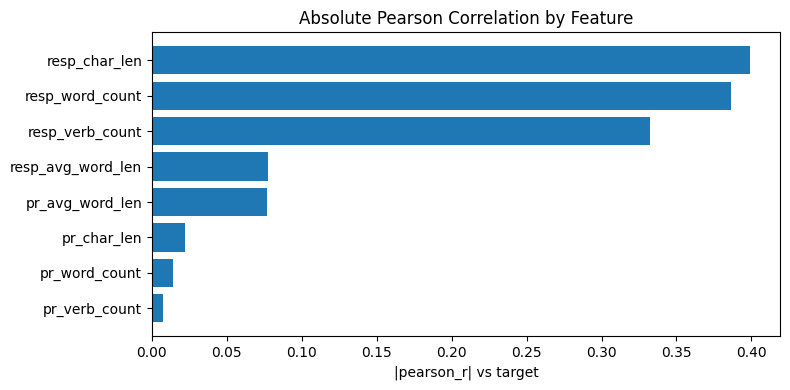

In [11]:

# === 7) Correlate each feature to target ===

from scipy.stats import spearmanr

# Align valid rows (non-NaN target)
mask_valid = df[target_col].notna()
feat_cols = list(features.columns)
Y = df.loc[mask_valid, target_col].astype(float)

def safe_pearson(x, y):
    if len(x) < 3:
        return np.nan
    try:
        return pd.Series(x, dtype=float).corr(pd.Series(y, dtype=float))
    except Exception:
        return np.nan

rows = []
for c in feat_cols:
    x = features.loc[mask_valid, c].astype(float)
    pear = safe_pearson(x, Y)
    # Spearman
    try:
        spear = spearmanr(x, Y, nan_policy="omit").correlation
    except Exception:
        spear = np.nan
    rows.append({
        "feature": c,
        "pearson_r": pear,
        "spearman_r": spear,
        "n": int(mask_valid.sum())
    })

corr_df = pd.DataFrame(rows).sort_values(by="pearson_r", key=lambda s: s.abs(), ascending=False).reset_index(drop=True)
display(corr_df)

# Save correlations
corr_df.to_csv("feature_correlations.csv", index=False)
print("Saved: feature_correlations.csv")

# Simple bar chart of |pearson_r|
plt.figure(figsize=(8, max(4, 0.4*len(corr_df))))
plt.barh(corr_df["feature"], corr_df["pearson_r"].abs())
plt.gca().invert_yaxis()
plt.xlabel("|pearson_r| vs target")
plt.title("Absolute Pearson Correlation by Feature")
plt.tight_layout()
plt.show()


In [12]:

# === 8) Save original df with features appended ===
df_with_features = pd.concat([df.reset_index(drop=True), features.reset_index(drop=True)], axis=1)
df_with_features.to_csv("df_with_features.csv", index=False)
print("Saved: df_with_features.csv")
display(df_with_features.head(3))


Saved: df_with_features.csv


,prompt,response,helpfulness,correctness,coherence,complexity,verbosity,overall_score,pr_word_count,pr_char_len,pr_avg_word_len,pr_verb_count,resp_word_count,resp_char_len,resp_avg_word_len,resp_verb_count
0,What are the three most important things to consider when deciding what technology to use to build an assist device to help an elderly person with basic needs?,"To build an assistive device to help an elderly person with basic needs, one must consider three crucial things: safety, compatibility, and ease of use. Safety is paramount, as the device must not...",3,4,4,2,2,15,28,159,4.678571,6,62,376,4.919355,10
1,What are the three most important things to consider when deciding what technology to use to build an assist device to help an elderly person with basic needs?,"There are many different types of assistive devices that can be used to help an elderly person with their basic needs. When deciding what technology to use to build an assistive device, it is impo...",4,3,3,2,3,15,28,159,4.678571,6,247,1470,4.825911,52
2,What are the three most important things to consider when deciding what technology to use to build an assist device to help an elderly person with basic needs?,"When deciding what technology to use to build an assist device to help an elderly person with basic needs, there are three most important things to consider:\n\n1. The specific needs of the elderl...",4,4,4,2,2,16,28,159,4.678571,6,130,794,4.953846,26


Found 13 numeric columns to test.


,feature,pearson_r,spearman_r,n_pairs,non_na_rate
0,correctness,0.841022,0.782646,35331,1.0
1,helpfulness,0.839732,0.778918,35331,1.0
2,coherence,0.687134,0.612227,35331,1.0
3,verbosity,0.630796,0.637740,35331,1.0
4,complexity,0.605361,0.604108,35331,1.0
5,resp_char_len,0.399105,0.421657,35331,1.0
6,resp_word_count,0.386378,0.409262,35331,1.0
7,resp_verb_count,0.332020,0.371244,35331,1.0
8,resp_avg_word_len,0.077693,0.113729,35331,1.0
9,pr_avg_word_len,0.076936,0.079039,35331,1.0


Saved: all_variable_correlations.csv


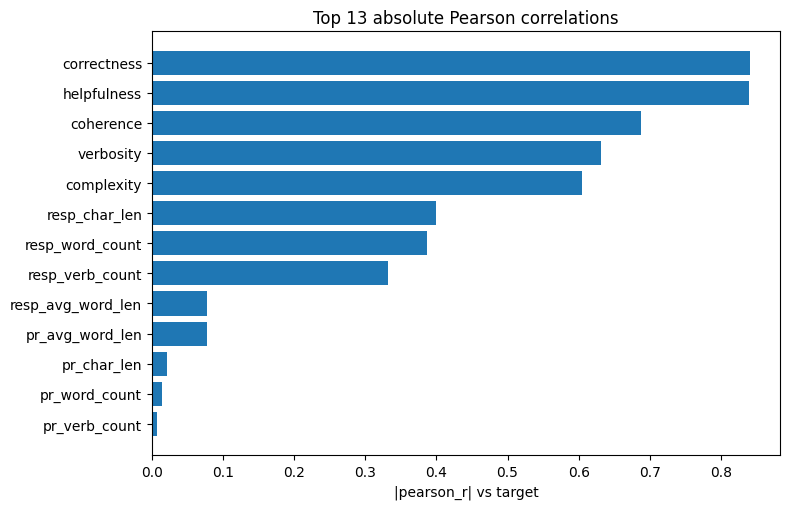

In [13]:

# === 10) Correlate every numeric variable (excluding raw prompt/response) to target ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Try to use the df_with_features created earlier; fall back to combining df + features
if 'df_with_features' not in globals():
    try:
        df_with_features = pd.concat([df.reset_index(drop=True), features.reset_index(drop=True)], axis=1)
        print("Constructed df_with_features from df + features:", df_with_features.shape)
    except Exception as e:
        raise RuntimeError("Expected `df_with_features` or (`df` and `features`) to be available.") from e

# Identify columns to exclude (raw text)
exclude_cols = set()
if 'prompt_col' in globals() and prompt_col in df_with_features.columns:
    exclude_cols.add(prompt_col)
if 'response_col' in globals() and response_col in df_with_features.columns:
    exclude_cols.add(response_col)

# Target column must exist
if 'target_col' not in globals() or target_col not in df_with_features.columns:
    raise KeyError("`target_col` not set or not in DataFrame. Run earlier cells to detect columns.")

# Select numeric columns except target
candidate_cols = []
for c in df_with_features.columns:
    if c in exclude_cols or c == target_col:
        continue
    if pd.api.types.is_numeric_dtype(df_with_features[c]):
        candidate_cols.append(c)

print(f"Found {len(candidate_cols)} numeric columns to test.")

# Prepare target vector
Y_all = pd.to_numeric(df_with_features[target_col], errors="coerce")

rows = []
for c in candidate_cols:
    x_all = pd.to_numeric(df_with_features[c], errors="coerce")
    pair = pd.DataFrame({"x": x_all, "y": Y_all}).dropna()
    n_pair = len(pair)
    if n_pair < 3:
        pear = np.nan
        spear = np.nan
    else:
        pear = pair["x"].corr(pair["y"])
        spear = spearmanr(pair["x"], pair["y"], nan_policy="omit").correlation
    rows.append({
        "feature": c,
        "pearson_r": pear,
        "spearman_r": spear,
        "n_pairs": int(n_pair),
        "non_na_rate": float(n_pair) / float(len(df_with_features)) if len(df_with_features) else np.nan
    })

all_corr_df = pd.DataFrame(rows).sort_values(by="pearson_r", key=lambda s: s.abs(), ascending=False).reset_index(drop=True)
display(all_corr_df.head(20))

# Save CSV of all correlations
ALL_CORR_CSV = "all_variable_correlations.csv"
all_corr_df.to_csv(ALL_CORR_CSV, index=False)
print(f"Saved: {ALL_CORR_CSV}")

# Bar chart of top-k absolute Pearson correlations
TOP_K = min(25, len(all_corr_df))
if TOP_K > 0:
    top = all_corr_df.iloc[:TOP_K]
    plt.figure(figsize=(8, max(4, 0.4*TOP_K)))
    plt.barh(top["feature"], top["pearson_r"].abs())
    plt.gca().invert_yaxis()
    plt.xlabel("|pearson_r| vs target")
    plt.title(f"Top {TOP_K} absolute Pearson correlations")
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns to plot.")


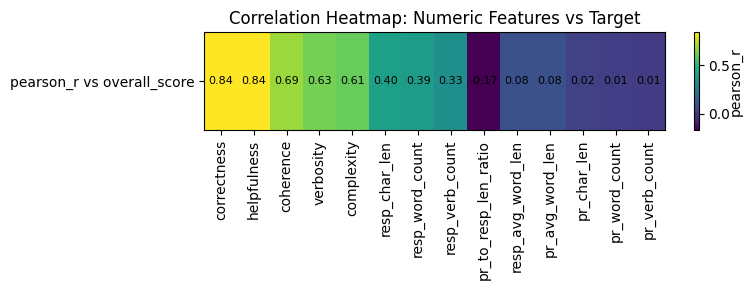

Added feature: pr_to_resp_len_ratio
Heatmap includes top 14 features by |pearson_r|.


In [15]:
# === Correlation heatmap (features vs target) + prompt/response length ratio ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# ---- Helper fallbacks (only used if earlier utils not defined) ----
def _tokens_fallback(text):
    if not isinstance(text, str):
        return []
    return re.findall(r"[A-Za-z0-9']+", text.lower())

def _word_count_fallback(text):
    return len(_tokens_fallback(text))

def _safe_div(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        out = a / b
        out[~np.isfinite(out)] = np.nan
    return out

# ---- Use df_with_features if available; else construct from df + features ----
if 'df_with_features' not in globals():
    try:
        df_with_features = pd.concat([df.reset_index(drop=True), features.reset_index(drop=True)], axis=1)
        print("Constructed df_with_features from df + features:", df_with_features.shape)
    except Exception as e:
        raise RuntimeError("Expected `df_with_features` or (`df` and `features`) to be available.") from e

# ---- Ensure we know the target and text columns (from earlier detection) ----
if 'target_col' not in globals() or target_col not in df_with_features.columns:
    raise KeyError("`target_col` not set or not in DataFrame. Re-run earlier detection cells.")

# If prompt/response col names exist, keep for exclusions. If not, try to guess minimally.
if 'prompt_col' not in globals() or prompt_col not in df_with_features.columns:
    for cand in ["prompt", "instruction", "input", "question"]:
        if cand in df_with_features.columns:
            prompt_col = cand
            break
if 'response_col' not in globals() or response_col not in df_with_features.columns:
    for cand in ["response", "output", "answer", "completion"]:
        if cand in df_with_features.columns:
            response_col = cand
            break

# ---- Add the prompt-to-response length ratio (word-count based) ----
# Prefer engineered word counts if present; otherwise compute lightweight counts on the fly.
if "pr_word_count" in df_with_features.columns and "resp_word_count" in df_with_features.columns:
    pr_wc = pd.to_numeric(df_with_features["pr_word_count"], errors="coerce")
    resp_wc = pd.to_numeric(df_with_features["resp_word_count"], errors="coerce")
else:
    # fallback to counting words from the raw text columns
    if (prompt_col is None) or (response_col is None):
        raise KeyError("Cannot compute word-count ratio: prompt/response columns not found.")
    pr_wc = df_with_features[prompt_col].map(_word_count_fallback).astype(float)
    resp_wc = df_with_features[response_col].map(_word_count_fallback).astype(float)

df_with_features["pr_to_resp_len_ratio"] = _safe_div(pr_wc, resp_wc)

# (Optional) If you prefer character length ratio instead, uncomment:
# df_with_features["pr_to_resp_char_ratio"] = _safe_div(
#     df_with_features.get("pr_char_len", df_with_features[prompt_col].astype(str).str.len()),
#     df_with_features.get("resp_char_len", df_with_features[response_col].astype(str).str.len())
# )

# ---- Build Pearson correlations of ALL numeric cols (minus raw text & minus target) vs target ----
exclude_cols = set()
if 'prompt_col' in globals() and prompt_col in df_with_features.columns:
    exclude_cols.add(prompt_col)
if 'response_col' in globals() and response_col in df_with_features.columns:
    exclude_cols.add(response_col)
exclude_cols.add(target_col)  # we don't want the trivial self-correlation

numeric_cols = [c for c in df_with_features.columns
                if c not in exclude_cols and pd.api.types.is_numeric_dtype(df_with_features[c])]

if not numeric_cols:
    raise RuntimeError("No numeric columns found to correlate against the target.")

# Compute Pearson correlations against target
target_vals = pd.to_numeric(df_with_features[target_col], errors="coerce")
corr_series = {}
for c in numeric_cols:
    x = pd.to_numeric(df_with_features[c], errors="coerce")
    pair = pd.DataFrame({"x": x, "y": target_vals}).dropna()
    corr_series[c] = pair["x"].corr(pair["y"]) if len(pair) >= 3 else np.nan

corr_s = pd.Series(corr_series, dtype=float).dropna()

# Order by absolute correlation for readability
corr_s = corr_s.reindex(corr_s.abs().sort_values(ascending=False).index)

# (Optional) Limit to top-K for a compact heatmap
TOP_K = min(40, len(corr_s))
corr_top = corr_s.iloc[:TOP_K]

# ---- Plot heatmap (1 x N) using matplotlib (no seaborn, no custom colors) ----
fig, ax = plt.subplots(figsize=(max(8, 0.35*TOP_K), 3))
heat_data = corr_top.values.reshape(1, -1)  # shape (1, N)
im = ax.imshow(heat_data, aspect='auto')  # default colormap

# Axis ticks & labels
ax.set_yticks([0])
ax.set_yticklabels([f"pearson_r vs {target_col}"])
ax.set_xticks(np.arange(TOP_K))
ax.set_xticklabels(corr_top.index, rotation=90)

# Annotate each cell with the correlation value (rounded)
for j, val in enumerate(corr_top.values):
    ax.text(j, 0, f"{val:.2f}", ha='center', va='center', fontsize=8)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.ax.set_ylabel("pearson_r", rotation=90, va="center")

ax.set_title("Correlation Heatmap: Numeric Features vs Target")
plt.tight_layout()
plt.show()

print("Added feature:", "pr_to_resp_len_ratio")
print("Heatmap includes top", TOP_K, "features by |pearson_r|.")


Using 10 features:
  pr_word_count, pr_char_len, pr_avg_word_len, pr_verb_count, resp_word_count, resp_char_len, resp_avg_word_len, resp_verb_count, pr_to_resp_len_ratio, pr_to_resp_len_ratio
CV R^2 (mean ± std): 0.1799 ± 0.0062

Hold-out metrics:
R^2 : 0.1829
MAE : 2.2724
RMSE: 2.9343
Saved predictions to: predictions_regression.csv
Saved coefficients to: model_coefficients.csv
Saved model pipeline to: ridge_pipeline.joblib


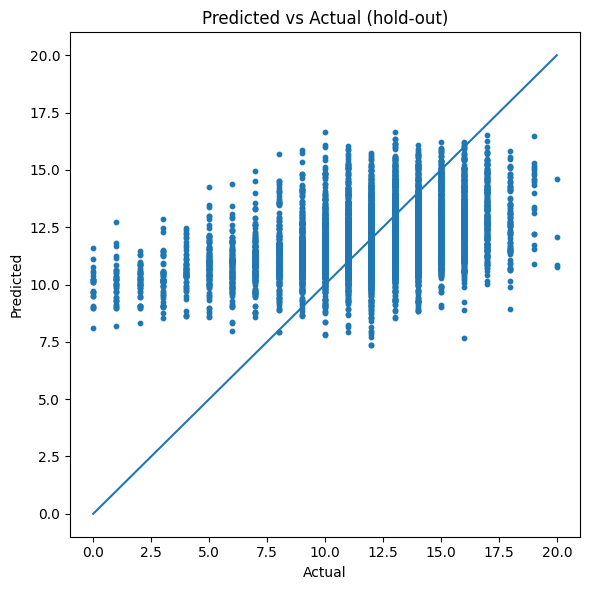

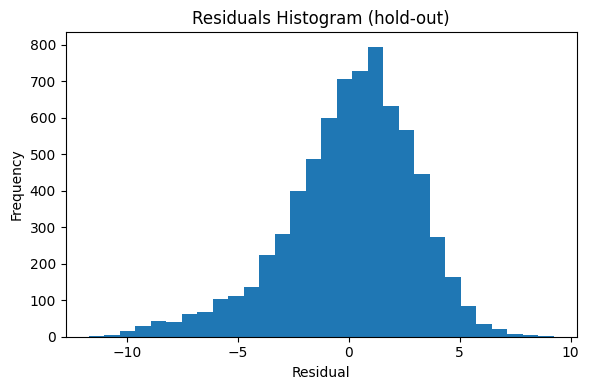

In [21]:

# === 11) Refit regression with engineered features ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ---- Use df_with_features; otherwise construct from df + features ----
if 'df_with_features' not in globals():
    try:
        df_with_features = pd.concat([df.reset_index(drop=True), features.reset_index(drop=True)], axis=1)
        print("Constructed df_with_features from df + features:", df_with_features.shape)
    except Exception as e:
        raise RuntimeError("Expected `df_with_features` or (`df` and `features`) to be available.") from e

# ---- Ensure prompt/response and target columns are present ----
if 'target_col' not in globals() or target_col not in df_with_features.columns:
    raise KeyError("`target_col` not set or not in DataFrame. Re-run earlier detection cells.")

# If missing, compute the prompt-to-response word-count ratio quickly
def _tokens_fallback(text):
    import re
    if not isinstance(text, str):
        return []
    return re.findall(r"[A-Za-z0-9']+", text.lower())

def _word_count_fallback(text):
    return len(_tokens_fallback(text))

def _safe_div(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        out = a / b
        out[~np.isfinite(out)] = np.nan
    return out

if "pr_to_resp_len_ratio" not in df_with_features.columns:
    if "pr_word_count" in df_with_features.columns and "resp_word_count" in df_with_features.columns:
        pr_wc = pd.to_numeric(df_with_features["pr_word_count"], errors="coerce")
        resp_wc = pd.to_numeric(df_with_features["resp_word_count"], errors="coerce")
    else:
        # Guess minimal prompt/response column names if not already set
        if 'prompt_col' not in globals() or prompt_col not in df_with_features.columns:
            for cand in ["prompt", "instruction", "input", "question"]:
                if cand in df_with_features.columns:
                    prompt_col = cand
                    break
        if 'response_col' not in globals() or response_col not in df_with_features.columns:
            for cand in ["response", "output", "answer", "completion"]:
                if cand in df_with_features.columns:
                    response_col = cand
                    break
        if (prompt_col is None) or (response_col is None):
            raise KeyError("Cannot compute word-count ratio: prompt/response columns not found.")
        pr_wc = df_with_features[prompt_col].map(_word_count_fallback).astype(float)
        resp_wc = df_with_features[response_col].map(_word_count_fallback).astype(float)

    df_with_features["pr_to_resp_len_ratio"] = _safe_div(pr_wc, resp_wc)

# ---- Select feature columns (engineered blocks + ratio) ----
candidate_feature_cols = [c for c in df_with_features.columns 
                          if (c.startswith("pr_") or c.startswith("resp_"))]

# ensure the ratio is included even if it doesn't start with the prefixes
if "pr_to_resp_len_ratio" in df_with_features.columns:
    candidate_feature_cols.append("pr_to_resp_len_ratio")

# Keep only numeric columns among candidates
X_cols = [c for c in candidate_feature_cols if pd.api.types.is_numeric_dtype(df_with_features[c])]
if not X_cols:
    raise RuntimeError("No numeric engineered features found. Re-run earlier feature-engineering cells.")

print(f"Using {len(X_cols)} features:\n  " + ", ".join(X_cols))

# Build X, y
y = pd.to_numeric(df_with_features[target_col], errors="coerce")
X = df_with_features[X_cols].apply(pd.to_numeric, errors="coerce")

# Drop rows with NaN in y; keep NaNs in X for the imputer
mask = y.notna()
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

# Train/validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# RidgeCV across log-spaced alphas
alphas = np.logspace(-3, 3, 25)

pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=True, with_std=True)),
    ("ridge", RidgeCV(alphas=alphas))

])

# 5-fold CV on the training split
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="r2")
print("CV R^2 (mean ± std):", f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Fit on training data
pipe.fit(X_train, y_train)

# Evaluate on hold-out
y_pred = pipe.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = float(np.sqrt(mse))

print("\nHold-out metrics:")
print("R^2 :", f"{r2:.4f}")
print("MAE :", f"{mae:.4f}")
print("RMSE:", f"{rmse:.4f}")

# Save predictions
pred_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred,
    "residual": y_test.values - y_pred
})
PRED_PATH = "predictions_regression.csv"
pred_df.to_csv(PRED_PATH, index=False)
print(f"Saved predictions to: {PRED_PATH}")

# Extract standardized coefficients
ridge = pipe.named_steps["ridge"]
imputer = pipe.named_steps["impute"]
scaler = pipe.named_steps["scale"]

# The coefficients correspond to the transformed feature space after imputation and scaling.
coef = ridge.coef_.ravel() if hasattr(ridge.coef_, "ravel") else np.asarray(ridge.coef_).ravel()
coef_df = pd.DataFrame({
    "feature": X_cols,
    "coef_standardized": coef
}).sort_values(by="coef_standardized", key=lambda s: s.abs(), ascending=False).reset_index(drop=True)

COEF_PATH = "model_coefficients.csv"
coef_df.to_csv(COEF_PATH, index=False)
print(f"Saved coefficients to: {COEF_PATH}")

# Persist model pipeline
try:
    import joblib
    MODEL_PATH = "ridge_pipeline.joblib"
    joblib.dump(pipe, MODEL_PATH)
    print(f"Saved model pipeline to: {MODEL_PATH}")
except Exception as e:
    print("Warning: could not save model pipeline with joblib:", e)

# ---- Plot: Predicted vs Actual ----
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=10)
# 45-degree line
mn = float(min(y_test.min(), y_pred.min()))
mx = float(max(y_test.max(), y_pred.max()))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (hold-out)")
plt.tight_layout()
plt.show()

# ---- Plot: Residuals histogram ----
plt.figure(figsize=(6,4))
plt.hist(pred_df["residual"].values, bins=30)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residuals Histogram (hold-out)")
plt.tight_layout()
plt.show()


Prediction clamp bounds (from TRAIN): [4.000, 24.995]  (mu=11.904, sd=3.273)
TRAIN (bounded) — R^2: 0.1805  MAE: 2.2952  RMSE: 2.9627

VALIDATION (bounded to 4σ, floor=4.0) — R^2: 0.1786  MAE: 2.2492  RMSE: 2.9078


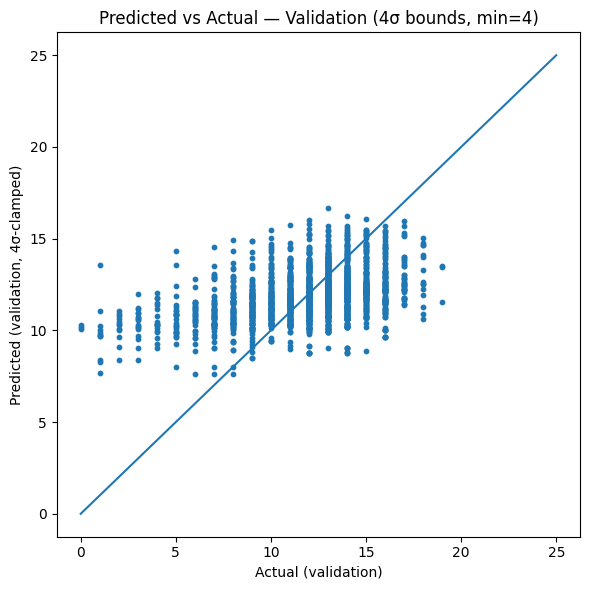

In [28]:
# === Bounded predictions: clamp to [max(4, mu-4*sd), mu+4*sd] from TRAIN ===
import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ---------- 0) Load/assure TRAIN DF and compute overall_score ----------
if 'df' not in globals():
    if os.path.exists("train.csv"):
        df = pd.read_csv("train.csv")
    else:
        raise FileNotFoundError("No DataFrame `df` and no train.csv found.")
need = ["helpfulness","correctness","coherence","complexity","verbosity"]
miss = [c for c in need if c not in df.columns]
if miss: raise KeyError(f"Train missing columns for overall_score: {miss}")
df["overall_score"] = df[need].sum(axis=1, min_count=1)
target_col = "overall_score"

# ---------- 1) Minimal text utilities ----------
_token_re = re.compile(r"[A-Za-z0-9']+")
def _tokens(x): return _token_re.findall(str(x).lower()) if isinstance(x,str) else []
def _wc(x): return len(_tokens(x))
def _cl(x): return len(str(x)) if isinstance(x,str) else 0
def _awl(x):
    t = _tokens(x); return float(np.mean([len(w) for w in t])) if t else 0.0
def _verb_count(x):
    if not isinstance(x,str): return 0
    cnt = 0
    for t in _tokens(x):
        if t.endswith("ed") or t.endswith("ing"): cnt += 1
    return cnt
def _safe_div(a,b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        z = a / b
        z[~np.isfinite(z)] = np.nan
    return z

def _build_side_features(s, prefix):
    return pd.DataFrame({
        f"{prefix}_word_count": s.map(_wc).astype("float32"),
        f"{prefix}_char_len": s.map(_cl).astype("float32"),
        f"{prefix}_avg_word_len": s.map(_awl).astype("float32"),
        f"{prefix}_verb_count": s.map(_verb_count).astype("float32"),
    })

def _guess(df, cands):
    m = {c.lower(): c for c in df.columns}
    for k in cands:
        if k.lower() in m: return m[k.lower()]
    return None

# ---------- 2) Engineer TRAIN features (leakage-free) ----------
pr_col = _guess(df, ["prompt","instruction","input","question"])
rs_col = _guess(df, ["response","output","answer","completion"])
if pr_col is None or rs_col is None:
    raise KeyError("Could not detect prompt/response columns in TRAIN.")

prF = _build_side_features(df[pr_col].fillna(""), "pr")
rsF = _build_side_features(df[rs_col].fillna(""), "resp")
featF = pd.concat([prF, rsF], axis=1)
featF["pr_to_resp_len_ratio"] = _safe_div(featF["pr_word_count"], featF["resp_word_count"])

df_with_features = pd.concat([df.reset_index(drop=True), featF.reset_index(drop=True)], axis=1)
X_cols = [c for c in df_with_features.columns if c.startswith("pr_") or c.startswith("resp_")]
if "pr_to_resp_len_ratio" not in X_cols:
    X_cols.append("pr_to_resp_len_ratio")

y_train = pd.to_numeric(df_with_features[target_col], errors="coerce")
X_train = df_with_features[X_cols].apply(pd.to_numeric, errors="coerce")
mask = y_train.notna()
X_train = X_train.loc[mask].reset_index(drop=True)
y_train = y_train.loc[mask].reset_index(drop=True)

# ---------- 3) Fit model on FULL TRAIN ----------
alphas = np.logspace(-3, 3, 25)
pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler(with_mean=True, with_std=True)),
    ("ridge",  RidgeCV(alphas=alphas))  # avoid store_cv_values for compat
])
pipe.fit(X_train, y_train)

# ---------- 4) Compute 4σ bounds from TRAIN (with floor at 4.0) ----------
mu = float(np.nanmean(y_train))
sd = float(np.nanstd(y_train, ddof=0))  # population sd OK here
lower = max(4.0, mu - 4.0*sd)           # never go below 4
upper = mu + 4.0*sd
if lower > upper: upper = lower  # degenerate safety
print(f"Prediction clamp bounds (from TRAIN): [{lower:.3f}, {upper:.3f}]  (mu={mu:.3f}, sd={sd:.3f})")

def predict_bounded(X):
    raw = pipe.predict(X)
    return np.clip(raw, lower, upper)

# ---------- 5) TRAIN metrics (bounded, for reference only) ----------
y_tr_pred = predict_bounded(X_train)
print("TRAIN (bounded) — R^2:", f"{r2_score(y_train, y_tr_pred):.4f}",
      " MAE:", f"{mean_absolute_error(y_train, y_tr_pred):.4f}",
      " RMSE:", f"{np.sqrt(mean_squared_error(y_train, y_tr_pred)):.4f}")

# ---------- 6) VALIDATION: engineer features, align columns, predict (bounded) ----------
if not os.path.exists("validation.csv"):
    raise FileNotFoundError("validation.csv not found.")

df_val = pd.read_csv("validation.csv")
v_missing = [c for c in need if c not in df_val.columns]
if v_missing: raise KeyError(f"Validation missing columns for overall_score: {v_missing}")
df_val["overall_score"] = df_val[need].sum(axis=1, min_count=1)

pr_val = pr_col if pr_col in df_val.columns else _guess(df_val, ["prompt","instruction","input","question"])
rs_val = rs_col if rs_col in df_val.columns else _guess(df_val, ["response","output","answer","completion"])
if pr_val is None or rs_val is None:
    raise KeyError("Could not detect prompt/response columns in VALIDATION.")

prV = _build_side_features(df_val[pr_val].fillna(""), "pr")
rsV = _build_side_features(df_val[rs_val].fillna(""), "resp")
featV = pd.concat([prV, rsV], axis=1)
featV["pr_to_resp_len_ratio"] = _safe_div(featV["pr_word_count"], featV["resp_word_count"])
df_val_with_features = pd.concat([df_val.reset_index(drop=True), featV.reset_index(drop=True)], axis=1)

for c in X_cols:
    if c not in df_val_with_features.columns:
        df_val_with_features[c] = np.nan
X_val = df_val_with_features[X_cols].apply(pd.to_numeric, errors="coerce")
y_val = pd.to_numeric(df_val_with_features[target_col], errors="coerce")
m = y_val.notna()
X_val, y_val = X_val.loc[m].reset_index(drop=True), y_val.loc[m].reset_index(drop=True)

y_val_pred = predict_bounded(X_val)

# ---------- 7) Report & plot ----------
val_r2  = r2_score(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse= float(np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("\nVALIDATION (bounded to 4σ, floor=4.0) — R^2:", f"{val_r2:.4f}",
      " MAE:", f"{val_mae:.4f}", " RMSE:", f"{val_rmse:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_val_pred, s=10)
mn = float(min(y_val.min(), lower))
mx = float(max(y_val.max(), upper))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Actual (validation)")
plt.ylabel("Predicted (validation, 4σ-clamped)")
plt.title("Predicted vs Actual — Validation (4σ bounds, min=4)")
plt.tight_layout()
plt.show()


Clamp bounds from TRAIN: [4.000, 24.995]  (mu=11.904, sd=3.273)

Validation results (sorted by bounded R^2):


,variant,features_used,val_R2_raw,val_MAE_raw,val_RMSE_raw,val_R2_bounded,val_MAE_bounded,val_RMSE_bounded
0,engineered_plus_correctness,10,0.777870,1.214268,1.512143,0.774156,1.223988,1.524731
1,engineered_plus_helpfulness,10,0.771873,1.227126,1.532419,0.768413,1.236658,1.543994
2,engineered_plus_coherence,10,0.590358,1.604754,2.053482,0.586790,1.611662,2.062406
3,engineered_plus_complexity,10,0.428537,1.878126,2.425397,0.428537,1.878126,2.425397
4,engineered_plus_verbosity,10,0.411608,1.900257,2.461059,0.411608,1.900257,2.461059
5,engineered_only,9,0.178591,2.249212,2.907827,0.178591,2.249212,2.907827


Saved: single_var_ablation_results.csv


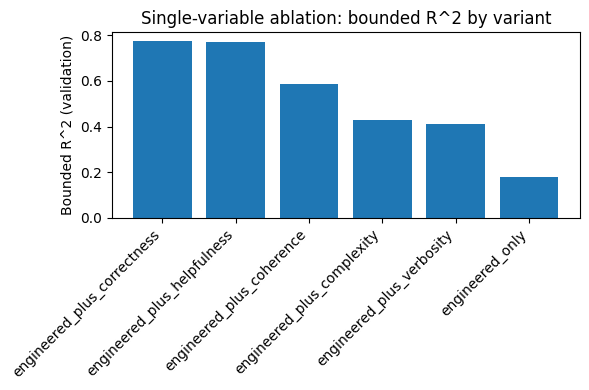

In [29]:
# Cell: Single-variable ablation — add ONE component score at a time (e.g., 'helpfulness') 
# to the engineered text features, then evaluate on validation. 
# Predictions are clamped to the TRAIN mean ± 4σ, with a hard floor of 4.0.
#
# Outputs:
# - Printed table of validation metrics per variant (baseline + each single variable)
# - Bar chart of bounded R^2 by variant
# - CSV: single_var_ablation_results.csv
#
# Assumptions:
# - `df` is loaded (else we try train.csv)
# - validation.csv is present
# - text columns named like 'prompt'/'response' (fallbacks included)
#
import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ---------------- Config ----------------
CLAMP_TO_4SIGMA = True
SIGMA_MULT = 4.0
FLOOR = 4.0                            # never predict below this
ALPHAS = np.logspace(-3, 3, 25)
COMPONENTS = ["helpfulness","correctness","coherence","complexity","verbosity"]

# -------- 0) Load TRAIN df if needed & compute overall_score --------
if 'df' not in globals():
    if os.path.exists("train.csv"):
        df = pd.read_csv("train.csv")
    else:
        raise FileNotFoundError("No `df` in memory and no train.csv found.")
missing = [c for c in COMPONENTS if c not in df.columns]
if missing:
    raise KeyError(f"Train DF missing required columns: {missing}")
df["overall_score"] = df[COMPONENTS].sum(axis=1, min_count=1)
target_col = "overall_score"

# -------- 1) Minimal text utils & feature engineering --------
_token_re = re.compile(r"[A-Za-z0-9']+")
def _tokens(x): return _token_re.findall(str(x).lower()) if isinstance(x,str) else []
def _wc(x): return len(_tokens(x))
def _cl(x): return len(str(x)) if isinstance(x,str) else 0
def _awl(x):
    t = _tokens(x); return float(np.mean([len(w) for w in t])) if t else 0.0
def _verb_count(x):
    if not isinstance(x,str): return 0
    cnt = 0
    for t in _tokens(x):
        if t.endswith("ed") or t.endswith("ing"): cnt += 1
    return cnt
def _safe_div(a,b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        z = a / b
        z[~np.isfinite(z)] = np.nan
    return z

def _build_side_features(s, prefix):
    return pd.DataFrame({
        f"{prefix}_word_count": s.map(_wc).astype("float32"),
        f"{prefix}_char_len": s.map(_cl).astype("float32"),
        f"{prefix}_avg_word_len": s.map(_awl).astype("float32"),
        f"{prefix}_verb_count": s.map(_verb_count).astype("float32"),
    })

def _guess(df, cands):
    m = {c.lower(): c for c in df.columns}
    for k in cands:
        if k.lower() in m: return m[k.lower()]
    return None

# Detect text cols in TRAIN
pr_col = _guess(df, ["prompt","instruction","input","question"])
rs_col = _guess(df, ["response","output","answer","completion"])
if pr_col is None or rs_col is None:
    raise KeyError("Could not detect prompt/response columns in TRAIN.")

# Engineer TRAIN features
prF = _build_side_features(df[pr_col].fillna(""), "pr")
rsF = _build_side_features(df[rs_col].fillna(""), "resp")
featF = pd.concat([prF, rsF], axis=1)
featF["pr_to_resp_len_ratio"] = _safe_div(featF["pr_word_count"], featF["resp_word_count"])

df_train = pd.concat([df.reset_index(drop=True), featF.reset_index(drop=True)], axis=1)

# Base engineered columns (leakage-free)
engineered_cols = [c for c in df_train.columns if c.startswith("pr_") or c.startswith("resp_")]
if "pr_to_resp_len_ratio" not in engineered_cols:
    engineered_cols.append("pr_to_resp_len_ratio")

# Training arrays
y_train = pd.to_numeric(df_train[target_col], errors="coerce")
X_engineered = df_train[engineered_cols].apply(pd.to_numeric, errors="coerce")
mask = y_train.notna()
y_train = y_train.loc[mask].reset_index(drop=True)
X_engineered = X_engineered.loc[mask].reset_index(drop=True)

# Train stats for clamping
mu = float(np.nanmean(y_train))
sd = float(np.nanstd(y_train, ddof=0))
if CLAMP_TO_4SIGMA:
    lower = max(FLOOR, mu - SIGMA_MULT * sd)
    upper = mu + SIGMA_MULT * sd
else:
    lower, upper = -np.inf, np.inf
print(f"Clamp bounds from TRAIN: [{lower:.3f}, {upper:.3f}]  (mu={mu:.3f}, sd={sd:.3f})")

def _predict_bounded(pipe, X):
    raw = pipe.predict(X)
    if np.isfinite(lower) or np.isfinite(upper):
        return np.clip(raw, lower, upper)
    return raw

# Load VALIDATION
if not os.path.exists("validation.csv"):
    raise FileNotFoundError("validation.csv not found for evaluation.")
df_val = pd.read_csv("validation.csv")
miss_v = [c for c in COMPONENTS if c not in df_val.columns]
if miss_v:
    raise KeyError(f"Validation DF missing required columns: {miss_v}")
df_val["overall_score"] = df_val[COMPONENTS].sum(axis=1, min_count=1)

# Engineer VALIDATION features
pr_val = pr_col if pr_col in df_val.columns else _guess(df_val, ["prompt","instruction","input","question"])
rs_val = rs_col if rs_col in df_val.columns else _guess(df_val, ["response","output","answer","completion"])
if pr_val is None or rs_val is None:
    raise KeyError("Could not detect prompt/response columns in VALIDATION.")

prV = _build_side_features(df_val[pr_val].fillna(""), "pr")
rsV = _build_side_features(df_val[rs_val].fillna(""), "resp")
featV = pd.concat([prV, rsV], axis=1)
featV["pr_to_resp_len_ratio"] = _safe_div(featV["pr_word_count"], featV["resp_word_count"])
df_val_full = pd.concat([df_val.reset_index(drop=True), featV.reset_index(drop=True)], axis=1)

# Helper: train on TRAIN with engineered + [optional single component], eval on VALIDATION
def fit_eval_single(label, extra_col=None):
    # Build feature set for TRAIN
    if extra_col is None:
        X_cols = list(engineered_cols)
    else:
        if extra_col not in df_train.columns:
            raise KeyError(f"Column '{extra_col}' not in TRAIN DataFrame.")
        X_cols = list(engineered_cols) + [extra_col]
    X_train = df_train[X_cols].apply(pd.to_numeric, errors="coerce").loc[mask].reset_index(drop=True)
    y_tr = y_train  # already filtered above

    # Pipeline
    pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale",  StandardScaler(with_mean=True, with_std=True)),
        ("ridge",  RidgeCV(alphas=ALPHAS))
    ])
    pipe.fit(X_train, y_tr)

    # Align VALIDATION columns
    X_val = df_val_full.reindex(columns=X_cols, fill_value=np.nan).apply(pd.to_numeric, errors="coerce")
    y_val = pd.to_numeric(df_val_full[target_col], errors="coerce")
    m = y_val.notna()
    X_val, y_val = X_val.loc[m].reset_index(drop=True), y_val.loc[m].reset_index(drop=True)

    # Predict (raw + bounded)
    y_pred_raw = pipe.predict(X_val)
    y_pred_bnd = np.clip(y_pred_raw, lower, upper)

    # Metrics
    def _metrics(y, yp):
        return {
            "R2": r2_score(y, yp),
            "MAE": mean_absolute_error(y, yp),
            "RMSE": float(np.sqrt(mean_squared_error(y, yp)))
        }
    met_raw = _metrics(y_val, y_pred_raw)
    met_bnd = _metrics(y_val, y_pred_bnd)

    return {
        "variant": label,
        "features_used": len(X_cols),
        "val_R2_raw": met_raw["R2"],
        "val_MAE_raw": met_raw["MAE"],
        "val_RMSE_raw": met_raw["RMSE"],
        "val_R2_bounded": met_bnd["R2"],
        "val_MAE_bounded": met_bnd["MAE"],
        "val_RMSE_bounded": met_bnd["RMSE"]
    }

# Run baseline (engineered only) + each single variable
results = []
results.append(fit_eval_single("engineered_only", extra_col=None))
for c in COMPONENTS:
    results.append(fit_eval_single(f"engineered_plus_{c}", extra_col=c))

res_df = pd.DataFrame(results).sort_values("val_R2_bounded", ascending=False).reset_index(drop=True)
print("\nValidation results (sorted by bounded R^2):")
display(res_df)

# Save results
RES_PATH = "single_var_ablation_results.csv"
res_df.to_csv(RES_PATH, index=False)
print(f"Saved: {RES_PATH}")

# Plot: bounded R^2 by variant
plt.figure(figsize=(max(6, 0.5*len(res_df)), 4))
plt.bar(range(len(res_df)), res_df["val_R2_bounded"].values)
plt.xticks(range(len(res_df)), res_df["variant"].tolist(), rotation=45, ha='right')
plt.ylabel("Bounded R^2 (validation)")
plt.title("Single-variable ablation: bounded R^2 by variant")
plt.tight_layout()
plt.show()


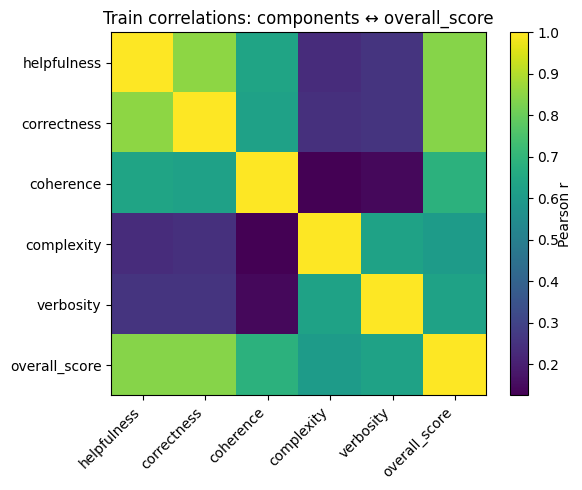

Clamp bounds from TRAIN: [4.000, 24.995]  (mu=11.904, sd=3.273)


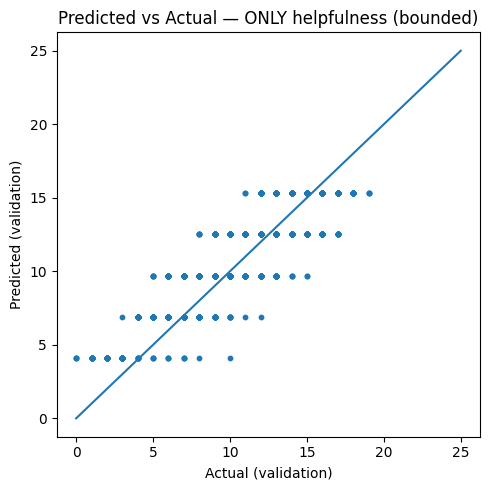


Correlations (TRAIN) for ONLY helpfulness:
                helpfulness  overall_score
helpfulness       1.000000       0.839732
overall_score     0.839732       1.000000

Correlations (VALIDATION) for ONLY helpfulness:
                helpfulness  overall_score
helpfulness       1.000000       0.841344
overall_score     0.841344       1.000000
------------------------------------------------------------


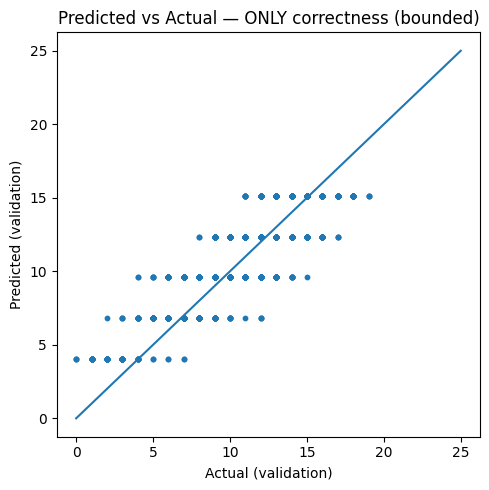


Correlations (TRAIN) for ONLY correctness:
                correctness  overall_score
correctness       1.000000       0.841022
overall_score     0.841022       1.000000

Correlations (VALIDATION) for ONLY correctness:
                correctness  overall_score
correctness       1.000000       0.843439
overall_score     0.843439       1.000000
------------------------------------------------------------


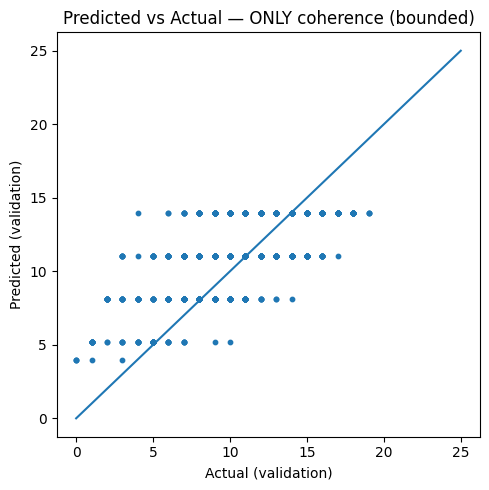


Correlations (TRAIN) for ONLY coherence:
                coherence  overall_score
coherence       1.000000       0.687134
overall_score   0.687134       1.000000

Correlations (VALIDATION) for ONLY coherence:
                coherence  overall_score
coherence       1.000000       0.696881
overall_score   0.696881       1.000000
------------------------------------------------------------


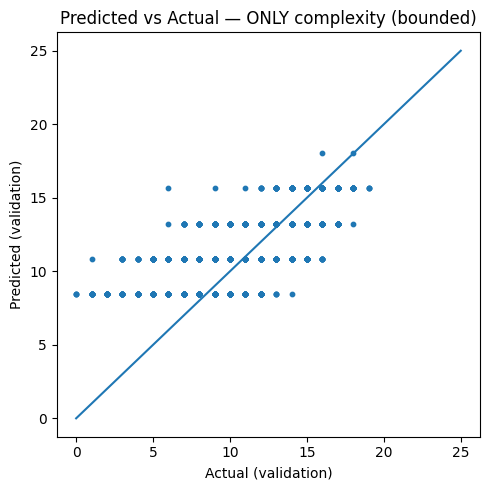


Correlations (TRAIN) for ONLY complexity:
                complexity  overall_score
complexity       1.000000       0.605361
overall_score    0.605361       1.000000

Correlations (VALIDATION) for ONLY complexity:
                complexity  overall_score
complexity       1.000000       0.623379
overall_score    0.623379       1.000000
------------------------------------------------------------


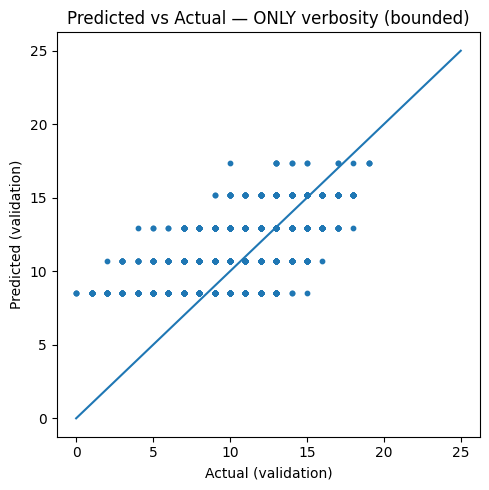


Correlations (TRAIN) for ONLY verbosity:
                verbosity  overall_score
verbosity       1.000000       0.630796
overall_score   0.630796       1.000000

Correlations (VALIDATION) for ONLY verbosity:
                verbosity  overall_score
verbosity       1.000000       0.611892
overall_score   0.611892       1.000000
------------------------------------------------------------

Validation metrics for ONLY models:


,variant,val_R2,val_MAE,val_RMSE
0,only_correctness,0.711087,1.393675,1.724536
1,only_helpfulness,0.707614,1.400172,1.734869
2,only_coherence,0.482362,1.775333,2.308351
3,only_complexity,0.386985,1.945248,2.512028
4,only_verbosity,0.373665,1.951445,2.539172


Saved: corr_train_components.csv, metrics_only_variants.csv, preds_only_<component>.csv


In [30]:
# === Correlations + "ONLY" models per component (bounded to μ±4σ, floor=4.0) ===
import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

COMPONENTS = ["helpfulness","correctness","coherence","complexity","verbosity"]
ALPHAS = np.logspace(-3, 3, 25)
SIGMA_MULT = 4.0
FLOOR = 4.0

# ---------- 0) Load TRAIN and VALIDATION, compute overall_score ----------
if 'df' not in globals():
    if os.path.exists("train.csv"):
        df = pd.read_csv("train.csv")
    else:
        raise FileNotFoundError("No `df` and no train.csv found.")

miss = [c for c in COMPONENTS if c not in df.columns]
if miss: raise KeyError(f"Train DF missing: {miss}")
df["overall_score"] = df[COMPONENTS].sum(axis=1, min_count=1)

if not os.path.exists("validation.csv"):
    raise FileNotFoundError("validation.csv not found.")
df_val = pd.read_csv("validation.csv")
miss_v = [c for c in COMPONENTS if c not in df_val.columns]
if miss_v: raise KeyError(f"Validation DF missing: {miss_v}")
df_val["overall_score"] = df_val[COMPONENTS].sum(axis=1, min_count=1)

target_col = "overall_score"

# ---------- 1) Train correlation matrix (components + overall_score) ----------
corr_cols = COMPONENTS + [target_col]
corr_train = df[corr_cols].corr(numeric_only=True)
corr_train.to_csv("corr_train_components.csv", index=True)

# Heatmap (matplotlib only)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr_train.values, aspect='auto')
ax.set_xticks(range(len(corr_cols))); ax.set_xticklabels(corr_cols, rotation=45, ha='right')
ax.set_yticks(range(len(corr_cols))); ax.set_yticklabels(corr_cols)
plt.colorbar(im, ax=ax).ax.set_ylabel("Pearson r", rotation=90, va="center")
ax.set_title("Train correlations: components ↔ overall_score")
plt.tight_layout(); plt.show()

# ---------- 2) Train stats for clamping (μ±4σ, floor=4.0) ----------
y_train_all = pd.to_numeric(df[target_col], errors="coerce").dropna()
mu = float(np.nanmean(y_train_all))
sd = float(np.nanstd(y_train_all, ddof=0))
lower = max(FLOOR, mu - SIGMA_MULT*sd)
upper = mu + SIGMA_MULT*sd
print(f"Clamp bounds from TRAIN: [{lower:.3f}, {upper:.3f}]  (mu={mu:.3f}, sd={sd:.3f})")

def clamp(pred):
    return np.clip(pred, lower, upper)

# ---------- 3) “ONLY” models: use a single component as X ----------
metrics = []
for comp in COMPONENTS:
    # Build X/y for TRAIN (single variable)
    X_tr = pd.to_numeric(df[[comp]].squeeze(), errors="coerce").to_frame()
    y_tr = pd.to_numeric(df[target_col], errors="coerce")
    m = y_tr.notna() & X_tr[comp].notna()
    X_tr, y_tr = X_tr.loc[m].reset_index(drop=True), y_tr.loc[m].reset_index(drop=True)

    # Pipeline (impute+scale+ridge)
    pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale",  StandardScaler(with_mean=True, with_std=True)),
        ("ridge",  RidgeCV(alphas=ALPHAS))
    ])
    pipe.fit(X_tr, y_tr)

    # Align VALIDATION and predict (bounded)
    X_v = pd.to_numeric(df_val[[comp]].squeeze(), errors="coerce").to_frame()
    y_v = pd.to_numeric(df_val[target_col], errors="coerce")
    mv = y_v.notna() & X_v[comp].notna()
    X_v, y_v = X_v.loc[mv].reset_index(drop=True), y_v.loc[mv].reset_index(drop=True)

    y_pred_raw = pipe.predict(X_v)
    y_pred = clamp(y_pred_raw)

    # Metrics (validation)
    r2  = r2_score(y_v, y_pred)
    mae = mean_absolute_error(y_v, y_pred)
    rmse= float(np.sqrt(mean_squared_error(y_v, y_pred)))

    metrics.append({
        "variant": f"only_{comp}",
        "val_R2": r2,
        "val_MAE": mae,
        "val_RMSE": rmse
    })

    # Save per-variant predictions
    pd.DataFrame({"y_true": y_v.values, "y_pred": y_pred}).to_csv(f"preds_only_{comp}.csv", index=False)

    # Scatter plot for this "ONLY" variant
    plt.figure(figsize=(5,5))
    plt.scatter(y_v, y_pred, s=10)
    mn = float(min(y_v.min(), lower)); mx = float(max(y_v.max(), upper))
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("Actual (validation)")
    plt.ylabel("Predicted (validation)")
    plt.title(f"Predicted vs Actual — ONLY {comp} (bounded)")
    plt.tight_layout(); plt.show()

    # 2×2 correlations for this example (TRAIN and VALIDATION)
    c_tr = df[[comp, target_col]].corr(numeric_only=True)
    c_v  = df_val[[comp, target_col]].corr(numeric_only=True)
    print(f"\nCorrelations (TRAIN) for ONLY {comp}:\n", c_tr)
    print(f"\nCorrelations (VALIDATION) for ONLY {comp}:\n", c_v)
    print("-"*60)

# Summary table
metrics_df = pd.DataFrame(metrics).sort_values("val_R2", ascending=False).reset_index(drop=True)
print("\nValidation metrics for ONLY models:")
display(metrics_df)
metrics_df.to_csv("metrics_only_variants.csv", index=False)
print("Saved: corr_train_components.csv, metrics_only_variants.csv, preds_only_<component>.csv")


Clamp bounds from TRAIN: [4.000, 24.995]  (mu=11.904, sd=3.273)
Saved: combo_var_ablation_results.csv

Best subset per size k:


,k,subset,val_R2_bounded,delta_R2_vs_baseline
0,0,engineered_only,0.178591,0.000000
1,1,correctness,0.774156,0.595565
2,2,helpfulness+complexity,0.887884,0.709293
3,3,correctness+coherence+verbosity,0.934143,0.755553
4,4,correctness+coherence+complexity+verbosity,0.967165,0.788574
5,5,helpfulness+correctness+coherence+complexity+verbosity,0.988488,0.809897


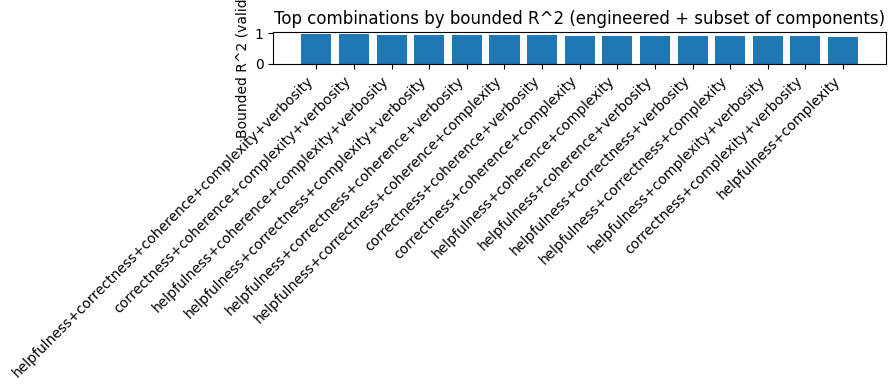

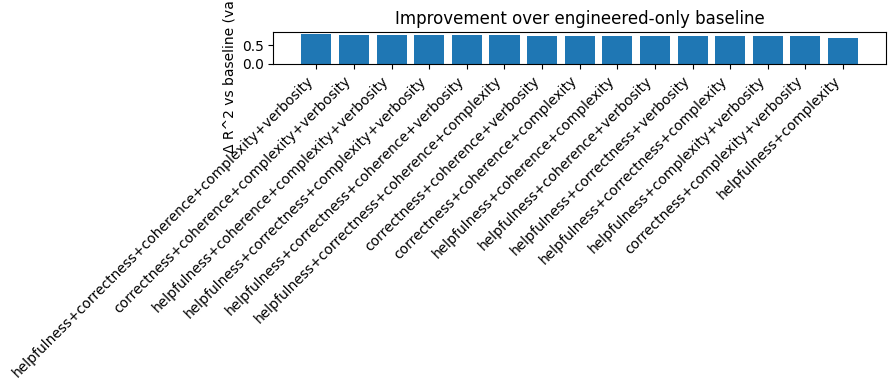

In [31]:
# === 14) Combination sweep: engineered features + any subset of components (bounded to μ±4σ, floor=4.0) ===
import os, re, itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

COMPONENTS = ["helpfulness","correctness","coherence","complexity","verbosity"]
ALPHAS = np.logspace(-3, 3, 25)
SIGMA_MULT = 4.0
FLOOR = 4.0

# ---------- 0) Load TRAIN & VALIDATION, compute overall_score ----------
if 'df' not in globals():
    if os.path.exists("train.csv"):
        df = pd.read_csv("train.csv")
    else:
        raise FileNotFoundError("No `df` in memory and no train.csv found.")
need = COMPONENTS
miss = [c for c in need if c not in df.columns]
if miss: raise KeyError(f"Train DF missing columns: {miss}")
df["overall_score"] = df[need].sum(axis=1, min_count=1)
target_col = "overall_score"

if not os.path.exists("validation.csv"):
    raise FileNotFoundError("validation.csv not found.")
df_val = pd.read_csv("validation.csv")
miss_v = [c for c in need if c not in df_val.columns]
if miss_v: raise KeyError(f"Validation DF missing columns: {miss_v}")
df_val["overall_score"] = df_val[need].sum(axis=1, min_count=1)

# ---------- 1) Minimal text utils and feature builders ----------
_token_re = re.compile(r"[A-Za-z0-9']+")
def _tokens(x): return _token_re.findall(str(x).lower()) if isinstance(x,str) else []
def _wc(x): return len(_tokens(x))
def _cl(x): return len(str(x)) if isinstance(x,str) else 0
def _awl(x):
    t = _tokens(x); return float(np.mean([len(w) for w in t])) if t else 0.0
def _verb_count(x):
    if not isinstance(x,str): return 0
    cnt = 0
    for t in _tokens(x):
        if t.endswith("ed") or t.endswith("ing"): cnt += 1
    return cnt
def _safe_div(a,b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        z = a / b
        z[~np.isfinite(z)] = np.nan
    return z
def _build_side_features(s, prefix):
    return pd.DataFrame({
        f"{prefix}_word_count": s.map(_wc).astype("float32"),
        f"{prefix}_char_len": s.map(_cl).astype("float32"),
        f"{prefix}_avg_word_len": s.map(_awl).astype("float32"),
        f"{prefix}_verb_count": s.map(_verb_count).astype("float32"),
    })
def _guess(df0, cands):
    m = {c.lower(): c for c in df0.columns}
    for k in cands:
        if k.lower() in m: return m[k.lower()]
    return None

# Detect text columns
pr_col = _guess(df, ["prompt","instruction","input","question"])
rs_col = _guess(df, ["response","output","answer","completion"])
if pr_col is None or rs_col is None:
    raise KeyError("Could not detect prompt/response columns in TRAIN.")

# Engineer TRAIN features
prF = _build_side_features(df[pr_col].fillna(""), "pr")
rsF = _build_side_features(df[rs_col].fillna(""), "resp")
featF = pd.concat([prF, rsF], axis=1)
featF["pr_to_resp_len_ratio"] = _safe_div(featF["pr_word_count"], featF["resp_word_count"])
df_train = pd.concat([df.reset_index(drop=True), featF.reset_index(drop=True)], axis=1)

engineered_cols = [c for c in df_train.columns if c.startswith("pr_") or c.startswith("resp_")]
if "pr_to_resp_len_ratio" not in engineered_cols:
    engineered_cols.append("pr_to_resp_len_ratio")

# Engineer VALIDATION features
pr_val = pr_col if pr_col in df_val.columns else _guess(df_val, ["prompt","instruction","input","question"])
rs_val = rs_col if rs_col in df_val.columns else _guess(df_val, ["response","output","answer","completion"])
if pr_val is None or rs_val is None:
    raise KeyError("Could not detect prompt/response columns in VALIDATION.")
prV = _build_side_features(df_val[pr_val].fillna(""), "pr")
rsV = _build_side_features(df_val[rs_val].fillna(""), "resp")
featV = pd.concat([prV, rsV], axis=1)
featV["pr_to_resp_len_ratio"] = _safe_div(featV["pr_word_count"], featV["resp_word_count"])
df_val_full = pd.concat([df_val.reset_index(drop=True), featV.reset_index(drop=True)], axis=1)

# Train stats for clamping (μ±4σ, floor=4.0)
y_tr_all = pd.to_numeric(df_train[target_col], errors="coerce").dropna()
mu = float(np.nanmean(y_tr_all))
sd = float(np.nanstd(y_tr_all, ddof=0))
lower = max(4.0, mu - 4.0*sd)
upper = mu + 4.0*sd
print(f"Clamp bounds from TRAIN: [{lower:.3f}, {upper:.3f}]  (mu={mu:.3f}, sd={sd:.3f})")

def evaluate_subset(subset_cols):
    # Build feature set for TRAIN
    X_cols = list(engineered_cols) + list(subset_cols)
    X_tr = df_train[X_cols].apply(pd.to_numeric, errors="coerce")
    y_tr = pd.to_numeric(df_train[target_col], errors="coerce")
    m = y_tr.notna()
    X_tr, y_tr = X_tr.loc[m].reset_index(drop=True), y_tr.loc[m].reset_index(drop=True)

    # Fit pipeline
    pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale",  StandardScaler(with_mean=True, with_std=True)),
        ("ridge",  RidgeCV(alphas=ALPHAS))
    ])
    pipe.fit(X_tr, y_tr)

    # Align validation features
    X_val = df_val_full.reindex(columns=X_cols, fill_value=np.nan).apply(pd.to_numeric, errors="coerce")
    y_val = pd.to_numeric(df_val_full[target_col], errors="coerce")
    mv = y_val.notna()
    X_val, y_val = X_val.loc[mv].reset_index(drop=True), y_val.loc[mv].reset_index(drop=True)

    # Predict and clamp
    y_pred_raw = pipe.predict(X_val)
    y_pred = np.clip(y_pred_raw, lower, upper)

    # Metrics (bounded)
    r2  = r2_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse= float(np.sqrt(mean_squared_error(y_val, y_pred)))

    return r2, mae, rmse, X_cols

# --- Run baseline + all non-empty subsets of COMPONENTS ---
results = []
subset_list = [()]  # baseline engineered-only
for k in range(1, len(COMPONENTS)+1):
    for combo in itertools.combinations(COMPONENTS, k):
        subset_list.append(combo)

for combo in subset_list:
    r2, mae, rmse, used_cols = evaluate_subset(combo)
    label = "engineered_only" if len(combo)==0 else "+".join(combo)
    results.append({
        "subset": label,
        "k": len(combo),
        "features_used": len(used_cols),
        "val_R2_bounded": r2,
        "val_MAE_bounded": mae,
        "val_RMSE_bounded": rmse
    })

res_df = pd.DataFrame(results).sort_values("val_R2_bounded", ascending=False).reset_index(drop=True)

# Improvement over engineered-only baseline
baseline_r2 = float(res_df.loc[res_df["subset"]=="engineered_only","val_R2_bounded"].iloc[0])
res_df["delta_R2_vs_baseline"] = res_df["val_R2_bounded"] - baseline_r2

# Save results
CSV_PATH = "combo_var_ablation_results.csv"
res_df.to_csv(CSV_PATH, index=False)
print(f"Saved: {CSV_PATH}")

# Best subset per size k
print("\nBest subset per size k:")
best_per_k = (res_df.sort_values(["k","val_R2_bounded"], ascending=[True, False])
                    .groupby("k").head(1).reset_index(drop=True))
display(best_per_k[["k","subset","val_R2_bounded","delta_R2_vs_baseline"]])

# Plot top-N by bounded R^2
TOP_N = min(15, len(res_df))
top = res_df.iloc[:TOP_N]
plt.figure(figsize=(max(8, 0.6*TOP_N), 4))
plt.bar(range(TOP_N), top["val_R2_bounded"].values)
plt.xticks(range(TOP_N), top["subset"].tolist(), rotation=45, ha='right')
plt.ylabel("Bounded R^2 (validation)")
plt.title("Top combinations by bounded R^2 (engineered + subset of components)")
plt.tight_layout()
plt.show()

# Plot delta vs baseline for the same TOP_N
plt.figure(figsize=(max(8, 0.6*TOP_N), 4))
plt.bar(range(TOP_N), top["delta_R2_vs_baseline"].values)
plt.xticks(range(TOP_N), top["subset"].tolist(), rotation=45, ha='right')
plt.ylabel("Δ R^2 vs baseline (validation)")
plt.title("Improvement over engineered-only baseline")
plt.tight_layout()
plt.show()


Clamp bounds from TRAIN: [4.000, 24.995]  (mu=11.904, sd=3.273)
Step 0 — R^2(val) with anchor ['correctness']: 0.7111
Step 1 — added resp_char_len → R^2(val)=0.7749
Step 2 — added resp_type_token_ratio → R^2(val)=0.7804
Step 3 — added resp_avg_sentence_len → R^2(val)=0.7818
Step 4 — added pr_type_token_ratio → R^2(val)=0.7820
Step 5 — added pr_qmark_ratio → R^2(val)=0.7825
Stopping at step 6: ΔR2=0.000090 < 0.0001

Best combo (anchored on 'correctness'):
['correctness', 'resp_char_len', 'resp_type_token_ratio', 'resp_avg_sentence_len', 'pr_type_token_ratio', 'pr_qmark_ratio']
Validation — R^2=0.7825, MAE=1.1993, RMSE=1.4962


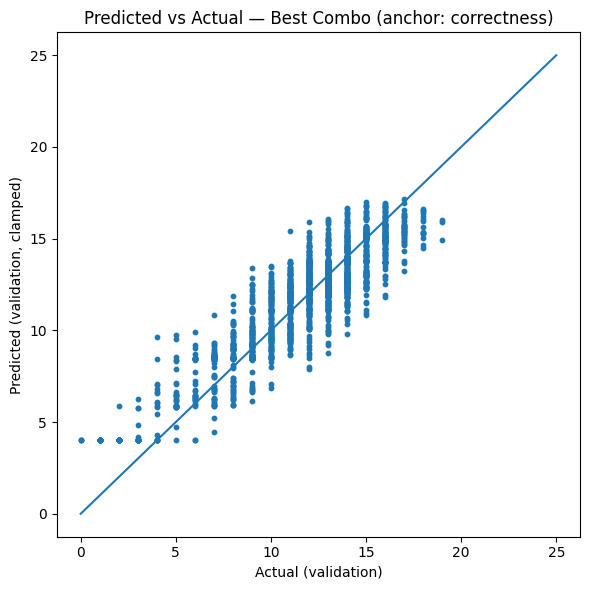

,step,added,R2,features
0,0,None,0.711087,[correctness]
1,1,resp_char_len,0.774910,"[correctness, resp_char_len]"
2,2,resp_type_token_ratio,0.780427,"[correctness, resp_char_len, resp_type_token_ratio]"
3,3,resp_avg_sentence_len,0.781753,"[correctness, resp_char_len, resp_type_token_ratio, resp_avg_sentence_len]"
4,4,pr_type_token_ratio,0.781996,"[correctness, resp_char_len, resp_type_token_ratio, resp_avg_sentence_len, pr_type_token_ratio]"
5,5,pr_qmark_ratio,0.782525,"[correctness, resp_char_len, resp_type_token_ratio, resp_avg_sentence_len, pr_type_token_ratio, pr_qmark_ratio]"


In [34]:
# === Forward stepwise: start with 'correctness', add engineered features from prompt & response, pick best R^2 ===
import os, re, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from itertools import chain
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ---------------- Config ----------------
ALPHAS = np.logspace(-3, 3, 25)
SIGMA_MULT = 4.0       # clamp to μ ± 4σ from TRAIN
FLOOR = 4.0            # never predict below this
MAX_STEPS = 20         # safety cap on number of added features (besides 'correctness')
MIN_IMPROVEMENT = 1e-4 # stop when ΔR2 < this

# ---------- 0) Load TRAIN/VAL and compute overall_score ----------
COMPONENTS = ["helpfulness","correctness","coherence","complexity","verbosity"]
if 'df' not in globals():
    if os.path.exists("train.csv"):
        df = pd.read_csv("train.csv")
    else:
        raise FileNotFoundError("No `df` and no train.csv found.")
miss = [c for c in COMPONENTS if c not in df.columns]
if miss: raise KeyError(f"Train DF missing: {miss}")
df["overall_score"] = df[COMPONENTS].sum(axis=1, min_count=1)
target_col = "overall_score"

if not os.path.exists("validation.csv"):
    raise FileNotFoundError("validation.csv not found.")
df_val = pd.read_csv("validation.csv")
miss_v = [c for c in COMPONENTS if c not in df_val.columns]
if miss_v: raise KeyError(f"Validation DF missing: {miss_v}")
df_val["overall_score"] = df_val[COMPONENTS].sum(axis=1, min_count=1)

# ---------- 1) Text utils (lightweight; no external NLP) ----------
_token_re = re.compile(r"[A-Za-z0-9']+")
_sentence_split_re = re.compile(r"[.!?]+")

ADJ_COMMON = {
    "good","bad","new","old","great","small","large","big","little","long","short","best","better","worse",
    "important","different","able","likely","possible","simple","difficult","easy","clear","strong","weak",
    "true","false","correct","incorrect","helpful","harmful","coherent","incoherent","complex","verbose"
}
ADJ_SUFFIXES = ("y","ful","less","ous","able","ible","ive","al","ic","ish","ary","ory","ant","ent")

def _tokens(x):
    return _token_re.findall(str(x)) if isinstance(x,str) else []

def _wc(x): return len(_tokens(x))
def _cl(x): return len(str(x)) if isinstance(x,str) else 0
def _awl(x):
    t = _tokens(x); 
    return float(np.mean([len(w) for w in t])) if t else 0.0

def _verb_count(x):
    # heuristic: common endings + tiny helper list
    if not isinstance(x,str): return 0
    t = [w.lower() for w in _tokens(x)]
    helpers = {"be","am","is","are","was","were","been","being","do","does","did","have","has","had",
               "will","would","shall","should","can","could","may","might","must"}
    cnt = 0
    for w in t:
        if w in helpers or (len(w)>3 and (w.endswith("ed") or w.endswith("ing"))):
            cnt += 1
    return cnt

def _adj_count(x):
    if not isinstance(x,str): return 0
    t = [w.lower() for w in _tokens(x)]
    cnt = 0
    for w in t:
        if w in ADJ_COMMON or w.endswith(ADJ_SUFFIXES):
            cnt += 1
    return cnt

def _type_token_ratio(x):
    t = [w.lower() for w in _tokens(x)]
    return float(len(set(t))/len(t)) if t else np.nan

def _punct_ratio(x):
    if not isinstance(x,str) or not x: return np.nan
    punct = sum(1 for ch in x if not ch.isalnum() and not ch.isspace())
    return punct / len(x)

def _digit_ratio(x):
    if not isinstance(x,str) or not x: return np.nan
    digs = sum(1 for ch in x if ch.isdigit())
    return digs / len(x)

def _upper_ratio(x):
    if not isinstance(x,str) or not x: return np.nan
    ups = sum(1 for ch in x if ch.isalpha() and ch.isupper())
    letters = sum(1 for ch in x if ch.isalpha())
    return (ups / letters) if letters > 0 else np.nan

def _avg_sentence_len(x):
    if not isinstance(x,str): return np.nan
    sents = [s for s in _sentence_split_re.split(x) if _wc(s) > 0]
    if not sents: return np.nan
    return float(np.mean([_wc(s) for s in sents]))

def _qmark_ratio(x):
    if not isinstance(x,str) or not x: return np.nan
    return x.count("?") / len(x)

def _exclam_ratio(x):
    if not isinstance(x,str) or not x: return np.nan
    return x.count("!") / len(x)

def _safe_div(a,b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        z = a / b
        z[~np.isfinite(z)] = np.nan
    return z

def _build_side_features(series, prefix):
    # Build the full feature set for one side (prompt/response)
    s = series.fillna("")
    df_feat = pd.DataFrame({
        f"{prefix}_word_count": s.map(_wc).astype("float32"),
        f"{prefix}_char_len": s.map(_cl).astype("float32"),
        f"{prefix}_avg_word_len": s.map(_awl).astype("float32"),
        f"{prefix}_verb_count": s.map(_verb_count).astype("float32"),
        f"{prefix}_adj_count": s.map(_adj_count).astype("float32"),
        f"{prefix}_type_token_ratio": s.map(_type_token_ratio).astype("float32"),
        f"{prefix}_punct_ratio": s.map(_punct_ratio).astype("float32"),
        f"{prefix}_digit_ratio": s.map(_digit_ratio).astype("float32"),
        f"{prefix}_upper_ratio": s.map(_upper_ratio).astype("float32"),
        f"{prefix}_avg_sentence_len": s.map(_avg_sentence_len).astype("float32"),
        f"{prefix}_qmark_ratio": s.map(_qmark_ratio).astype("float32"),
        f"{prefix}_exclam_ratio": s.map(_exclam_ratio).astype("float32"),
    })
    # Ratios derived from counts
    df_feat[f"{prefix}_verb_ratio"] = _safe_div(df_feat[f"{prefix}_verb_count"], df_feat[f"{prefix}_word_count"])
    df_feat[f"{prefix}_adj_ratio"]  = _safe_div(df_feat[f"{prefix}_adj_count"],  df_feat[f"{prefix}_word_count"])
    return df_feat

def _guess(df0, cands):
    m = {c.lower(): c for c in df0.columns}
    for k in cands:
        if k.lower() in m: return m[k.lower()]
    return None

# ---------- 2) Engineer features (TRAIN & VALIDATION) ----------
pr_col = _guess(df, ["prompt","instruction","input","question"])
rs_col = _guess(df, ["response","output","answer","completion","question"])
if pr_col is None or rs_col is None:
    raise KeyError("Could not detect prompt/response columns in TRAIN.")

prF = _build_side_features(df[pr_col], "pr")
rsF = _build_side_features(df[rs_col], "resp")
feat_train = pd.concat([prF, rsF], axis=1)
feat_train["pr_to_resp_len_ratio"] = _safe_div(feat_train["pr_word_count"], feat_train["resp_word_count"])

df_train_full = pd.concat([df.reset_index(drop=True), feat_train.reset_index(drop=True)], axis=1)

# Validation
pr_val = pr_col if pr_col in df_val.columns else _guess(df_val, ["prompt","instruction","input","question"])
rs_val = rs_col if rs_col in df_val.columns else _guess(df_val, ["response","output","answer","completion","question"])
if pr_val is None or rs_val is None:
    raise KeyError("Could not detect prompt/response columns in VALIDATION.")

prV = _build_side_features(df_val[pr_val], "pr")
rsV = _build_side_features(df_val[rs_val], "resp")
feat_val = pd.concat([prV, rsV], axis=1)
feat_val["pr_to_resp_len_ratio"] = _safe_div(feat_val["pr_word_count"], feat_val["resp_word_count"])
df_val_full = pd.concat([df_val.reset_index(drop=True), feat_val.reset_index(drop=True)], axis=1)

# ---------- 3) Candidate pool (engineered features only) ----------
engineered_candidates = list(feat_train.columns) + ["pr_to_resp_len_ratio"]

# ---------- 4) Anchor + train stats for clamping ----------
anchor = ["correctness"]  # always include
y_tr_all = pd.to_numeric(df_train_full[target_col], errors="coerce").dropna()
mu = float(np.nanmean(y_tr_all))
sd = float(np.nanstd(y_tr_all, ddof=0))
lower = max(FLOOR, mu - SIGMA_MULT*sd)
upper = mu + SIGMA_MULT*sd
print(f"Clamp bounds from TRAIN: [{lower:.3f}, {upper:.3f}]  (mu={mu:.3f}, sd={sd:.3f})")

# ---------- 5) Helper to fit/eval a given feature subset ----------
from sklearn.base import clone
def fit_eval(selected_cols):
    X_tr = df_train_full[selected_cols].apply(pd.to_numeric, errors="coerce")
    y_tr = pd.to_numeric(df_train_full[target_col], errors="coerce")
    m = y_tr.notna()
    X_tr, y_tr = X_tr.loc[m].reset_index(drop=True), y_tr.loc[m].reset_index(drop=True)

    pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale",  StandardScaler(with_mean=True, with_std=True)),
        ("ridge",  RidgeCV(alphas=ALPHAS))
    ])
    pipe.fit(X_tr, y_tr)

    # Align validation columns
    X_val = df_val_full.reindex(columns=selected_cols, fill_value=np.nan).apply(pd.to_numeric, errors="coerce")
    y_val = pd.to_numeric(df_val_full[target_col], errors="coerce")
    mv = y_val.notna()
    X_val, y_val = X_val.loc[mv].reset_index(drop=True), y_val.loc[mv].reset_index(drop=True)

    # Predict & clamp
    y_pred_raw = pipe.predict(X_val)
    y_pred = np.clip(y_pred_raw, lower, upper)

    r2  = r2_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse= float(np.sqrt(mean_squared_error(y_val, y_pred)))
    return r2, mae, rmse, pipe, y_val, y_pred

# ---------- 6) Forward stepwise selection (anchored on correctness) ----------
remaining = [c for c in engineered_candidates if c not in anchor]
selected = list(anchor)
best_r2, _, _, best_pipe, best_y, best_pred = fit_eval(selected)
path = [{"step": 0, "added": None, "R2": best_r2, "features": list(selected)}]
print(f"Step 0 — R^2(val) with anchor {anchor}: {best_r2:.4f}")

for step in range(1, MAX_STEPS+1):
    trial_scores = []
    for cand in remaining:
        r2, _, _, _, _, _ = fit_eval(selected + [cand])
        trial_scores.append((r2, cand))
    if not trial_scores:
        break
    r2_best_cand, best_cand = max(trial_scores, key=lambda x: x[0])
    if (r2_best_cand - best_r2) > MIN_IMPROVEMENT:
        selected.append(best_cand)
        remaining.remove(best_cand)
        best_r2 = r2_best_cand
        r2, mae, rmse, best_pipe, best_y, best_pred = fit_eval(selected)
        path.append({"step": step, "added": best_cand, "R2": r2, "features": list(selected)})
        print(f"Step {step} — added {best_cand} → R^2(val)={r2:.4f}")
    else:
        print(f"Stopping at step {step}: ΔR2={r2_best_cand - best_r2:.6f} < {MIN_IMPROVEMENT}")
        break

# ---------- 7) Report best combo ----------
print("\nBest combo (anchored on 'correctness'):")
print(selected)
r2, mae, rmse, _, y_val_best, y_pred_best = fit_eval(selected)
print(f"Validation — R^2={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")

# Save artifacts
pd.DataFrame({"y_true": y_val_best.values, "y_pred": y_pred_best}).to_csv("best_combo_predictions_validation.csv", index=False)
with open("best_combo_features.json","w") as f:
    json.dump({"selected_features": selected, "R2_val": r2, "MAE_val": mae, "RMSE_val": rmse}, f, indent=2)
try:
    import joblib
    joblib.dump(best_pipe, "best_combo_ridge_pipeline.joblib")
except Exception as e:
    print("Warning: could not save model pipeline:", e)

# Optional: visualize pred vs actual for the best combo
plt.figure(figsize=(6,6))
plt.scatter(y_val_best, y_pred_best, s=10)
mn = float(min(y_val_best.min(), lower)); mx = float(max(y_val_best.max(), upper))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Actual (validation)")
plt.ylabel("Predicted (validation, clamped)")
plt.title("Predicted vs Actual — Best Combo (anchor: correctness)")
plt.tight_layout(); plt.show()

# (Optional) Inspect the stepwise path:
pd.DataFrame(path)



---

### (Optional) 9) Run on validation
If you have a validation CSV (e.g., `validation.csv`), repeat the same process by replacing `df` with `df_val` and reusing the same feature functions.
